<a href="https://colab.research.google.com/github/Thiziri-Hafir/Donnees_Massives/blob/main/quarto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 70.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=da082dddba3ade76f465a3dd1dae7c04fadcd8e806537528c9a9c1b12f9f1b06
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


# Importing the data

In [ ]:
import pyspark
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession

SparkContext.setSystemProperty('spark.executor.memory', '8g')
SparkContext.setSystemProperty('spark.driver.memory', '45G')

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("Python Spark").getOrCreate()

In [ ]:
url = "https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv"
raw_arabica = pd.read_csv(url)

In [ ]:
from pyspark.sql.types import *

# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return DoubleType()
    elif f == 'float32': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return spark.createDataFrame(pandas_df, p_schema)

In [ ]:
df_arabica = pandas_to_spark(raw_arabica)

# Basic structural transformations and harmonization

## Renaming columns and selecting the columns and rows of interest

In [ ]:
tempList = [] #Edit01
for col in df_arabica.columns:
        new_name = col.strip()
        new_name = "".join(new_name.split())
        new_name = new_name.replace('.','_') # EDIT
        tempList.append(new_name) #Edit02
print(tempList) #Just for the sake of it #Edit03

df_arabica = df_arabica.toDF(*tempList) #Edit04

['Unnamed:0', 'Species', 'Owner', 'Country_of_Origin', 'Farm_Name', 'Lot_Number', 'Mill', 'ICO_Number', 'Company', 'Altitude', 'Region', 'Producer', 'Number_of_Bags', 'Bag_Weight', 'In_Country_Partner', 'Harvest_Year', 'Grading_Date', 'Owner_1', 'Variety', 'Processing_Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean_Cup', 'Sweetness', 'Cupper_Points', 'Total_Cup_Points', 'Moisture', 'Category_One_Defects', 'Quakers', 'Color', 'Category_Two_Defects', 'Expiration', 'Certification_Body', 'Certification_Address', 'Certification_Contact', 'unit_of_measurement', 'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']


#### We decided to focus on Brazil as it's on of the biggest coffee producer and presents interesting geoclimatic features and diversity

In [ ]:
df_arabica = df_arabica.filter(df_arabica["Country_of_Origin"]=='Brazil')\
          .distinct()\
          .select(["Farm_name","Altitude","Variety","Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Uniformity","Clean_Cup","Sweetness","Total_Cup_Points","altitude_mean_meters"])
df_arabica.show(100, 100)

+-----------------------------------+--------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
|                          Farm_name|      Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|
+-----------------------------------+--------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
|                 fazenda capoeirnha|           890|       Bourbon| 7.67|  7.58|       7.5|   7.58|7.58|    7.5|      10.0|     10.0|     10.0|           82.92|               890.0|
|                       olhos d'agua|          900m|           NaN| 7.58|  7.75|      7.67|    7.5|7.67|   7.58|      10.0|     10.0|     10.0|           83.17|               900.0|
|                        capoeirinha|           905|Yellow Bourbon| 7.58|  7.58|      7.58

In [ ]:
df_arabica = df_arabica.na.drop(subset=["altitude_mean_meters"]) 

In [ ]:
df_arabica.show(10,10)

+----------+--------+----------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
| Farm_name|Altitude|   Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|
+----------+--------+----------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+
|fazenda...|     890|   Bourbon| 7.67|  7.58|       7.5|   7.58|7.58|    7.5|      10.0|     10.0|     10.0|           82.92|               890.0|
|olhos d...|    900m|       NaN| 7.58|  7.75|      7.67|    7.5|7.67|   7.58|      10.0|     10.0|     10.0|           83.17|               900.0|
|capoeir...|     905|Yellow ...| 7.58|  7.58|      7.58|    7.5|7.67|   7.58|      10.0|     10.0|     10.0|           83.08|               905.0|
|capoeir...|     905|Yellow ...|  7.5|   7.5|      7.58|    7.5|7.58|   7.58|      10.0|     10.0|     10.0|          

We can se that we need to harmonize the Altitude column and link the Farm_name to spatial positions

## Harmonizing the altitude column

## Linking Farm_names to actual longitudes and latitudes

We created by hand a dataset with the position of the fields of each Farm_name and performed a simple outer_join

In [ ]:
df_farms = spark.createDataFrame(
    [
        ("fazenda rio verde",-21.877600079894428, -45.17833587173798 ),  # create your data here, be consistent in the types.
        ("fazenda do lobo", -20.05845833645814, -45.551377369807916),
        ("fazenda grota funda",-4.498676298642221, -46.01438009152326),
        ("sitio claro",-12.404400112670487, -57.0307320652044),
        ("santa alina",-21.76121880758086, -46.674253002625804),
        ("fazenda chamusca",-21.4532483711391, -45.22708818550831),
        ("santa maria",-16.609194745742165, -46.98365752985455),
        ("capoeirinha",-18.64698614414741, -45.796849953979795),
        ("fazenda do sertao",-22.09933939187727, -45.18968007378277),
        ("santa fé 2",-17.582654936016926, -47.2198752950817),
        ("café do paraíso",-22.094568087843687, -45.155496432162685),
        ("cachoeira da grama farm",-21.76626556295618, -46.702161544954144),
        ("são francisco da serra",-22.629913000779446, -44.601043902591805),
        ("fazenda jericó",-18.676315608302055, -45.70281563093488),
        ("sertao farm",-22.099418916815903, -45.18965861611114),
        ("campo das flores",-20.312258124962906, -43.28548394936318),
        ("olhos d'agua",-18.63831446703355, -46.952789277527444),
        ("fazenda serra de três barras",-19.560780988980817, -46.579303497451384),
        ("fazenda pantano",-18.631997524421426, -46.82473127385452),
        ("pereira estate coffee",-22.112480964214626, -45.15508902245408),
        ("rio verde",-21.940510105475326, -45.176192869009476),
        ("sitío são geraldo",-22.59528143237296, -46.66759241371165),
        ("fazenda baipendi",-21.45008093579659, -46.8357381855336),
        ("água limpa",-21.44645605895183, -46.82635044153258),
        ("fazenda kaquend",-21.435236392716707, -46.83244978479159),
        ("fazenda santo antonio",-21.40862617568116, -46.80560442679252),
        ("fazenda vista alegre",-21.44237673402853, -46.818513026788274),
        ("fazenda recreio",-21.780100162105256, -46.67880344388111),
        ("fazenda capoeirnha",-21.761009557830032, -46.67507912298348),
        ("pantano",-21.444638601462618, -46.81747769417689),
        ("fazenda são sebastião",-21.444863288363614, -46.827235570452125),
        ("santa bárbara",-18.52732198399872, -47.569893903127564),
        ("santa mariana",-23.19046310851501, -50.55948683365515),
        ("sertao",-22.095760723175886, -45.189755175672296),
        ("são rafael_ ra/ras certified",-22.784292492565246, -47.032534461666536),
        ("sitío santa luzia",-22.366016295045306, -46.47371725096838),
        ("fazenda são josé mirante",-22.785019797545694, -47.03177457322967),
        ("cianorte",-22.774138613223663, -47.02968245276757),
        ("juliana",-21.46270024286904, -46.832515362350975),
        ("sitío corrego da olaria/são caetano",-22.745464486282955, -47.0338567362583),
        ("fazenda serra negra",-21., -46.674253002625804),
        ("fazendas klem ltda",-20.27591897959779, -41.876604035124465),
        ("castelhana farm",-18.922960557030457, -47.45831617257145),
        ("leticia farm",-19.807319369835636, -42.215697182335234),
        ("helena",-22.107657064931225, -48.32067672583973),
        ("caxambu",-21.339808722609096, -45.42201735838091),
    ],
    ["Farm_name", "lat","long"]  # add your column names here
)

In [ ]:
df_arabica = df_arabica.join(df_farms, on=['Farm_name'], how='left_outer')

In [ ]:
df_arabica.show(10)

+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|           Farm_name|    Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|
+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|   fazenda rio verde|        1260|Yellow Bourbon| 7.58|  7.83|      7.67|   7.25| 8.0|   7.75|      10.0|     10.0|     10.0|            84.0|              1260.0|-21.877600079894428| -45.17833587173798|
| fazenda grota funda|       1200m|       Bourbon|  8.0|  7.92|      7.75|   7.75| 8.0|   7.75|      10.0|     10.0|     10.0|           84.92|              1200.0| -4.498676298642

### We then filter the coffee where we don't know where it came from

In [ ]:
df_arabica = df_arabica.filter(df_arabica.Farm_name != "NaN")
df_arabica.show(10)

+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|           Farm_name|    Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|
+--------------------+------------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|   fazenda rio verde|        1260|Yellow Bourbon| 7.58|  7.83|      7.67|   7.25| 8.0|   7.75|      10.0|     10.0|     10.0|            84.0|              1260.0|-21.877600079894428| -45.17833587173798|
| fazenda grota funda|       1200m|       Bourbon|  8.0|  7.92|      7.75|   7.75| 8.0|   7.75|      10.0|     10.0|     10.0|           84.92|              1200.0| -4.498676298642

In [ ]:
df_arabica = df_arabica.replace(float('nan'), None)
#

df_arabica.show(10)

+--------------------+--------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|           Farm_name|Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|altitude_mean_meters|                lat|               long|
+--------------------+--------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+--------------------+-------------------+-------------------+
|fazenda são sebas...|   1000m|    Mundo Novo| 7.42|  7.33|      7.25|   7.42| 7.5|   7.17|      10.0|     10.0|     10.0|           81.17|              1000.0|-21.444863288363614|-46.827235570452125|
|       santa bárbara|    1020|        Catuai| 7.42|  7.33|      7.33|    7.5| 7.5|   7.33|      10.0|     10.0|     10.0|           81.92|              1020.0| -18.52732198399872|-47.569893903127

In [ ]:
df_arabica = df_arabica.na.fill(value='unknown',subset=["Variety"])

# Data Exploration and plotting

In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(df_arabica.toPandas(), lat="lat", lon="long", hover_name="Farm_name", hover_data=["altitude_mean_meters",], color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

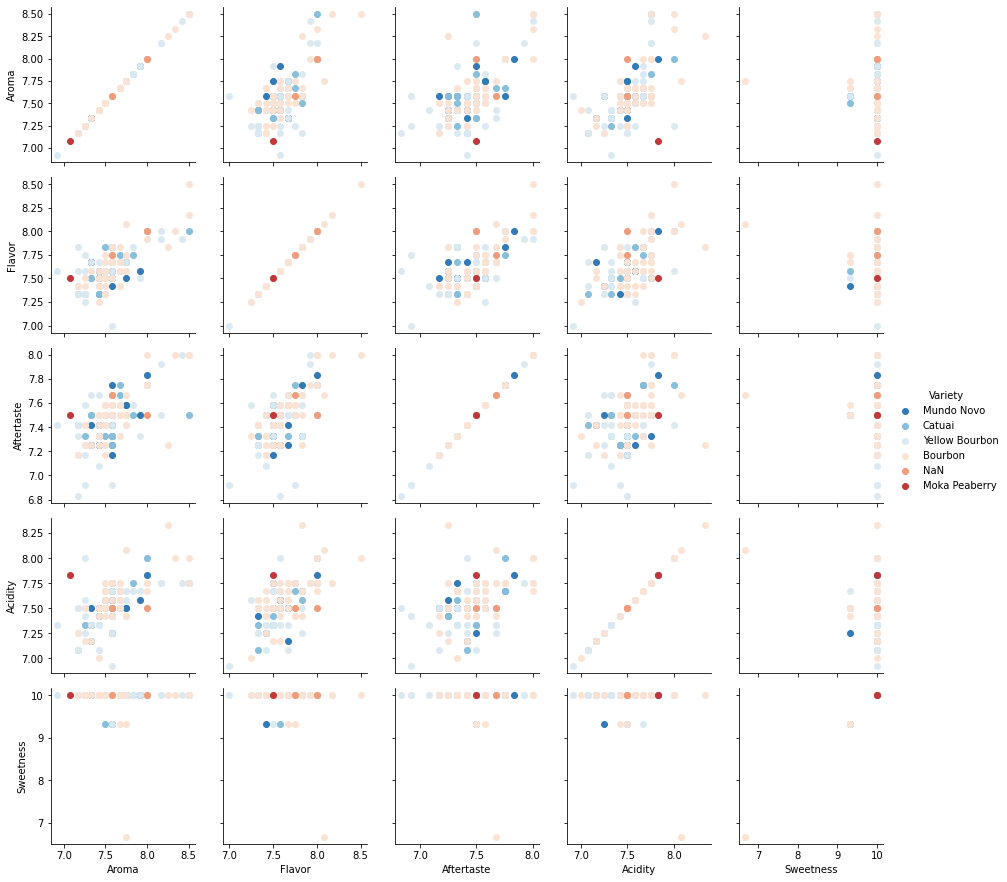

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(df_arabica.toPandas(), vars=['Aroma','Flavor','Aftertaste','Acidity','Sweetness'],
                 hue='Variety', palette='RdBu_r')
g.map(plt.scatter, alpha=0.99)
g.add_legend();

## Taste profile and scoring relation 

### With a simple linear regression we can find how the multiple taste variables influence the Total_Cup_Score

#### Creating the features vector

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Uniformity","Clean_Cup","Sweetness"], outputCol = 'features')
vec_df_arabica = vectorAssembler.transform(df_arabica)

#### Train test splitting

In [ ]:
train_taste,test_taste  = vec_df_arabica.randomSplit([0.7, 0.3])

(pun intended)

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Total_Cup_Points', maxIter=10)
lr_model = lr.fit(train_taste)
print("Coefficients: " + str(lr_model.coefficients[:5])+ "\n"+ str(lr_model.coefficients[5:]))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.05635594 1.28773544 1.33618124 0.82773426 1.36568876]
[1.15611252 1.30309993 0.87730216 0.98438806]
Intercept: -1.8148061947722982


#### Predicting and evaluating the model

In [ ]:
lr_predictions = lr_model.transform(test_taste)
lr_predictions.select("prediction","Total_Cup_Points","features").show(5)

+-----------------+----------------+--------------------+
|       prediction|Total_Cup_Points|            features|
+-----------------+----------------+--------------------+
|  80.238440625615|            80.5|[7.25,7.33,7.17,7...|
| 80.9160097447618|            81.0|[7.25,7.25,7.17,7...|
|81.89128824016232|            82.0|[7.33,7.67,7.42,7...|
| 83.3482992356964|           83.17|[7.75,7.67,7.58,7...|
|  83.039947071551|            83.0|[7.5,7.67,7.58,7....|
+-----------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Total_Cup_Points",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.974851


#### Our model fits quite well we can proceed to interpretation

#### Interpretation of taste A FAIRE

In [ ]:
####Franchement jsp

## Variety and scoring relation

#### For this one we will just use visualizations

In [ ]:
var = df_arabica.groupBy("Variety").mean("Total_Cup_Points")
var.show()

+--------------+---------------------+
|       Variety|avg(Total_Cup_Points)|
+--------------+---------------------+
|Yellow Bourbon|           82.6246875|
|    Mundo Novo|            82.484375|
|        Catuai|    82.31157894736843|
|        Arusha|    82.33500000000001|
|       Bourbon|    82.86075000000001|
|           NaN|              82.2075|
| Moka Peaberry|                82.92|
+--------------+---------------------+



In [ ]:
px.bar(var.toPandas(), x='Variety', y='avg(Total_Cup_Points)')

Not a very convincing plot, the Total_Cup_Points are very close (in the 80-90 range) and variety doesn't seem to matter that much

## Farm and scoring relation

# Nouvelle section

In [ ]:
farmr = df_arabica.groupBy("Farm_name").mean("Total_Cup_Points")
farmr.show()

+--------------------+---------------------+
|           Farm_name|avg(Total_Cup_Points)|
+--------------------+---------------------+
|fazenda são sebas...|                81.17|
|       santa bárbara|                81.92|
|   fazenda rio verde|              83.1875|
|     fazenda do lobo|                83.17|
|       santa mariana|                82.42|
| fazenda grota funda|                84.92|
|              sertao|                 81.5|
|         sitio claro|                84.92|
|são rafael_ ra/ra...|                80.25|
|         santa alina|                84.33|
|   sitío santa luzia|                82.33|
|fazenda são josé ...|                81.08|
|    fazenda chamusca|                82.58|
|         santa maria|               80.545|
|         capoeirinha|               82.892|
|   são josé da lagoa|                 82.0|
|   fazenda do sertao|    83.16499999999999|
|fazenda rio brilh...|                81.42|
|          santa fé 2|                82.83|
|   fazend

In [ ]:
px.bar(farmr.toPandas().sort_values(by=['avg(Total_Cup_Points)']), x='Farm_name', y='avg(Total_Cup_Points)')

#### Once again the plot is uninteresting, we can try to scale Total_Cup_Points to see more clearly (and with it let's do it on the tastes column since they suffer the same problem)

## Normalizing

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf

In [ ]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
df_arabica_scaled = df_arabica

for i in ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Total_Cup_Points"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df_arabica_scaled = pipeline.fit(df_arabica_scaled).transform(df_arabica_scaled).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
df_arabica_scaled.show(5)

After Scaling :
+--------------------+--------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+-------------------+-------------------+------------+-------------+-----------------+--------------+-----------+--------------+-----------------------+
|           Farm_name|Altitude|       Variety|Aroma|Flavor|Aftertaste|Acidity|Body|Balance|Uniformity|Clean_Cup|Sweetness|Total_Cup_Points|               long|                lat|Aroma_Scaled|Flavor_Scaled|Aftertaste_Scaled|Acidity_Scaled|Body_Scaled|Balance_Scaled|Total_Cup_Points_Scaled|
+--------------------+--------+--------------+-----+------+----------+-------+----+-------+----------+---------+---------+----------------+-------------------+-------------------+------------+-------------+-----------------+--------------+-----------+--------------+-----------------------+
|fazenda são sebas...|   1000m|    Mundo Novo| 7.42|  7.33|      7.25|   7.42| 7.5|   7.17|      10.0|     10.0

source : https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark

# Back to Exploration

## Let's try again the previous plots

## Variety

In [ ]:
var = df_arabica_scaled.groupBy("Variety").mean("Total_Cup_Points_Scaled")
px.bar(var.toPandas(), x='Variety', y='avg(Total_Cup_Points_Scaled)')

Still not great

## Farms

In [ ]:
farmr = df_arabica_scaled.groupBy("Farm_name").mean("Total_Cup_Points_Scaled")
px.bar(farmr.toPandas().sort_values(by=['avg(Total_Cup_Points_Scaled)']), x='Farm_name', y='avg(Total_Cup_Points_Scaled)')

### Way clearer

We can see that farms are more important than / offer more distinction than variety, we will se furthermore

## From now on we will use only the scaled version

In [ ]:
df_arabica = df_arabica_scaled

cols = ("Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Total_Cup_Points")
df_arabica = df_arabica.drop(*cols)
for i in ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance","Total_Cup_Points"]:
                   df_arabica = df_arabica.withColumnRenamed(i+"_Scaled", i)

df_arabica.show()
df_arabica.printSchema()

+--------------------+--------------+--------------+----------+---------+---------+-------------------+-------------------+-----+------+----------+-------+-----+-------+----------------+
|           Farm_name|      Altitude|       Variety|Uniformity|Clean_Cup|Sweetness|               long|                lat|Aroma|Flavor|Aftertaste|Acidity| Body|Balance|Total_Cup_Points|
+--------------------+--------------+--------------+----------+---------+---------+-------------------+-------------------+-----+------+----------+-------+-----+-------+----------------+
|fazenda são sebas...|         1000m|    Mundo Novo|      10.0|     10.0|     10.0|-21.444863288363614|-46.827235570452125|0.353|  0.22|     0.359|  0.355|0.447|  0.254|             0.4|
|       santa bárbara|          1020|        Catuai|      10.0|     10.0|     10.0| -18.52732198399872|-47.569893903127564|0.353|  0.22|     0.427|  0.411|0.447|  0.373|           0.479|
|   fazenda rio verde|          1260|Yellow Bourbon|      10.0|  

## Farms all of fame and their strengths

### Since farms seem interesting we can plot radar plots of the taste they offer (meaned).
We will focus on the most renowed farms

In [ ]:
from pyspark.sql.functions import desc
hof = df_arabica.groupBy("Farm_name").mean("Total_Cup_Points").sort(desc("avg(Total_Cup_Points)"))
hof.show(6)

+--------------------+---------------------+
|           Farm_name|avg(Total_Cup_Points)|
+--------------------+---------------------+
|     fazenda kaquend|                0.956|
|     fazenda recreio|                0.852|
|fazenda serra de ...|                0.844|
|   sitío são geraldo|                  0.8|
|         sitio claro|                0.791|
| fazenda grota funda|                0.791|
+--------------------+---------------------+
only showing top 6 rows



We will take the top 3

# FAIIIIIIIIIRE

In [ ]:
li = hof.select("Farm_name").take(3)[:3]

In [ ]:
li

[Row(Farm_name='fazenda kaquend'),
 Row(Farm_name='fazenda recreio'),
 Row(Farm_name='fazenda serra de três barras')]

In [ ]:
li = ["fazenda kaquend","fazenda recreio","sitío são geraldo","sitio claro","fazenda grota funda"]

Meaner par farm

In [ ]:
df_hof = df_arabica.filter(df_arabica.Farm_name.isin(li))
df_hof.show()

+-------------------+--------+----------+----------+---------+---------+-------------------+------------------+-----+------+----------+-------+-----+-------+----------------+
|          Farm_name|Altitude|   Variety|Uniformity|Clean_Cup|Sweetness|               long|               lat|Aroma|Flavor|Aftertaste|Acidity| Body|Balance|Total_Cup_Points|
+-------------------+--------+----------+----------+---------+---------+-------------------+------------------+-----+------+----------+-------+-----+-------+----------------+
|fazenda grota funda|   1200m|   Bourbon|      10.0|     10.0|     10.0| -4.498676298642221|-46.01438009152326|0.701| 0.613|     0.786|  0.589| 0.78|  0.687|           0.791|
|        sitio claro|  1000 m|    Catuai|      10.0|     10.0|     10.0|-12.404400112670487| -57.0307320652044|0.701| 0.667|     0.786|  0.766|0.447|  0.687|           0.791|
|  sitío são geraldo|   1100m|Mundo Novo|      10.0|     10.0|     10.0| -22.59528143237296|-46.66759241371165|0.701| 0.667| 

In [ ]:
import plotly.graph_objects as go
from pyspark.sql.functions import mean

categories = ["Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance"]

df_hof_pd = df_hof.select(["Farm_name","Aroma","Flavor","Aftertaste",\
                   "Acidity","Body","Balance"]).toPandas().set_index('Farm_name')


df_mean_pd = df_arabica.select(mean("Aroma"), mean("Flavor")\
                               , mean("Aftertaste"), mean("Acidity"), mean("Body"), mean("Balance"))\
                               .toPandas()

fig = go.Figure()

for g in df_hof_pd.index:
    fig.add_trace(go.Scatterpolar(
        r = df_hof_pd.loc[g].values,
        theta = categories,
        fill = "toself",
        name = f'{g}'
    ))


fig.add_trace(go.Scatterpolar(
        r = df_mean_pd.values,
        theta = categories,
        fill = "toself",
        name = f'MEAN'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0, 1]
    )),
  showlegend=False
)

fig.show()